# Makemore Part 
 * Activation, Grads, Bachnorm

In [65]:
import torch
import random
import matplotlib.pyplot as plt
import torch.nn.functional as F



In [66]:
words = open('names.txt', 'r').read().splitlines()
words[:4]

['emma', 'olivia', 'ava', 'isabella']

In [67]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocabSiz = len(itos)
print(itos)
print(vocabSiz)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [68]:
def buildDataset(words):
    blocksiz = 3
    X, Y = [], []
    for w in words:
        contxt = [0] * blocksiz
        for ch in w + '.':
            ix = stoi[ch]
            X.append(contxt)
            Y.append(ix)
            contxt = contxt[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))    
n2 = int(0.9*len(words))

xTrain, yTrain = buildDataset(words[:n1])
xDev, yDev = buildDataset(words[n1:n2])
xTst, yTst = buildDataset(words[n2:])




# How to find those scales 
 +  w1 = torch.ra.....     * 0.2   #scales
 +  b1 = torch.randn.....  * 0.01  #scales
 +  w2 = torch.randn.....  * 0.01  #scales
 +  b2 = torch.randn.....  * 0

tensor(0.0196) tensor(1.0082)
tensor(0.0050) tensor(1.0172)


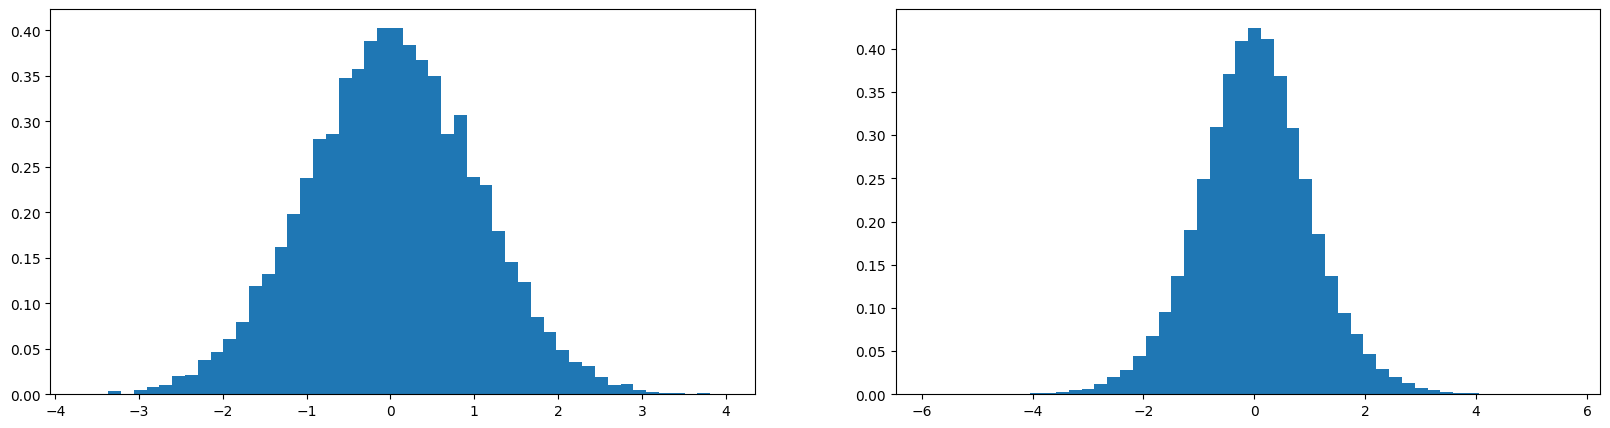

In [61]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5 #read ``` delvin deep into rectifier``` paper
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True); 
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True); 


In [80]:
nEmb = 10 #dim
nHidden = 200
blocksiz = 3
g = torch.Generator().manual_seed(2147483647)               #Read the docc...
C = torch.randn(vocabSiz,              nEmb, generator=g)   # orch.nn.init.kaiming-^ gain/fan_in
w1 = torch.randn((nEmb * blocksiz), nHidden, generator=g) * (5/3)/(nEmb * blocksiz)**0.5  #0.2
#b1 = torch.randn(nHidden,                    generator=g) * 0.01
w2 = torch.randn(nHidden, vocabSiz,          generator=g) * 0.01 #to lower the loss ::
b2 = torch.randn(vocabSiz,                   generator=g) * 0 #to lower the loss :: 
                                                          # it got 27.4-->3.7which is expected

#Batch normalizing Gain, bais
bngain = torch.ones((1, nHidden))
bnbias = torch.zeros((1, nHidden))

bnmeanRunning = torch.zeros((1, nHidden))
bnstdRunning =  torch.ones((1, nHidden))

para = [C, w1, w2, b2, bngain, bnbias]                                 
print(sum(p.nelement() for p in para))
for p in para:
    p.requires_grad = True

12097


In [78]:
maxSteps = 200000
batchSiz = 32
loss_i = []

for i in range(maxSteps):
    ix = torch.randint(0, xTrain.shape[0], (batchSiz,), generator=g)
    Xb, Yb = xTrain[ix], yTrain[ix] #batch x/y

    #forwardPass
    emb = C[Xb]
    embCat = emb.view(emb.shape[0], -1) #concatinating the vec
    #Also we dont need this b1 bais,, cos its gonna sub in hlprereact, INSTEAD WE'VE [bnbias]
    hlPreReact = embCat @ w1 #+ b1 # hidden layer pre-activation
    #starndadizing Activation / Batch Norm .. || Read the papaer
    
    #since we lazy doing mean/stp in postTraining do it in running manner
    bnmean_i = hlPreReact.mean(0, keepdim=True)
    bnstd_i = hlPreReact.std(0, keepdim=True)
    hlPreReact = bngain * (hlPreReact - bnmean_i) / bnstd_i + bnbias
     #hlPreReact = bngain * (hlPreReact - hlPreReact.mean(0, keepdim=True)) / (hlPreReact.std(0, keepdim=True)) + bnbias
    
    with torch.no_grad():
        bnmeanRunning = 0.999 * bnmeanRunning + 0.001 * bnmean_i
        bnstdRunning = 0.999 * bnstdRunning + 0.001 * bnstd_i


    h = torch.tanh(hlPreReact) #hidden layer
    logits = h @ w2 + b2 #output layer
    loss = F.cross_entropy(logits, Yb)

    #backward pass
    for p in para:
        p.grad = None
    loss.backward()

    # learning rate decay
    lr = 0.1 if i < 100000 else 0.01
    for p in para:
        p.data += -lr * p.grad

    if i % 10000 == 0: #print evry once in a while
        print(f'{i:7d}/{maxSteps:7d}: {loss.item():.4f}')
    loss_i.append(loss.log10().item())
    


      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


In [46]:
#expeted loss
-torch.tensor(1/27.0).log()

tensor(3.2958)

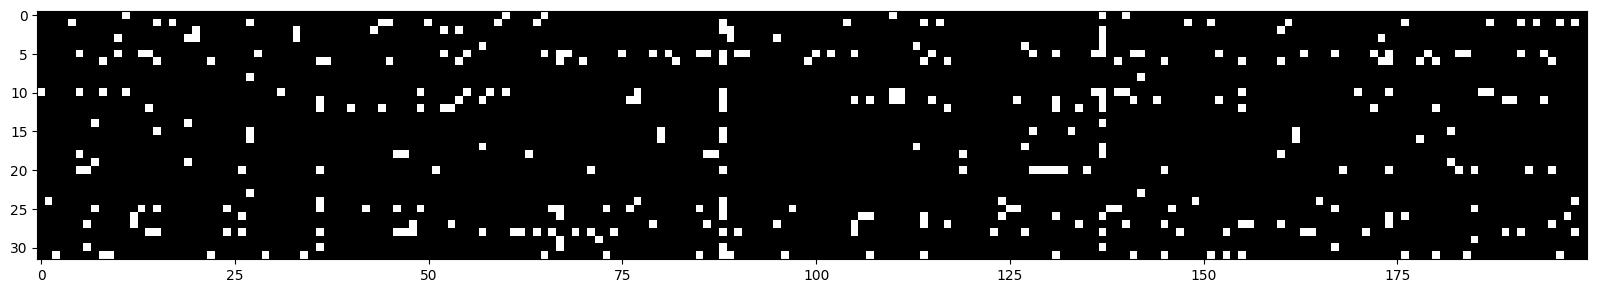

In [47]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')
#following output is a Boolean Tensor, say white True Back False
#if whole column could've been white Which Mean it's a Dead Neuron Didnt learn cos The inputs land on the tail of tnah
# that tanh neuron fire when only 1 or -1, it didnt respond/active for between 1&-1 inputs... so it didnt learn cos all grad==0

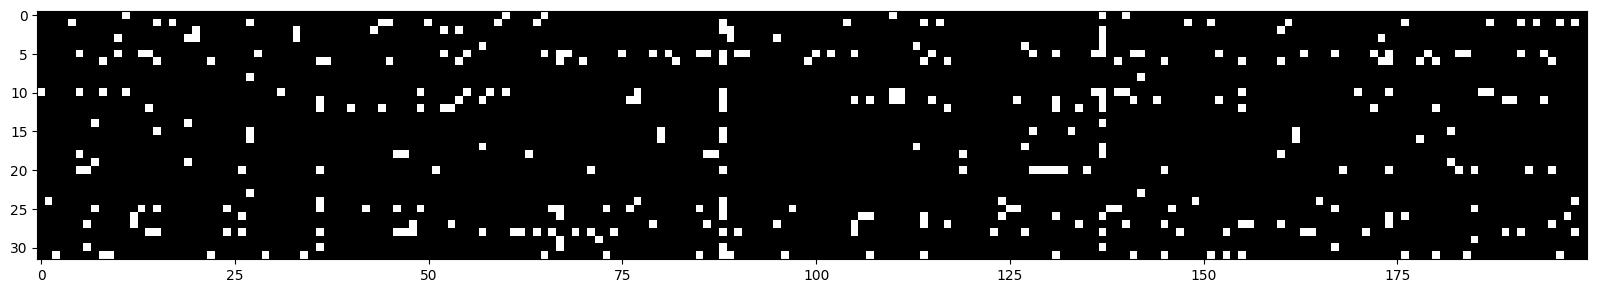

In [48]:
#after  fix tanh layer too saturated at init[para];
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')



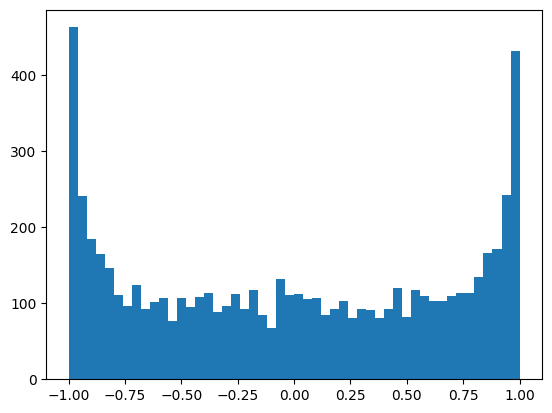

In [49]:
#histagram of h[tanh func] 
#h.view(-1).shape
#h.view(-1).tolist() //conver to one large python list
plt.hist(h.view(-1).tolist(), 50); 


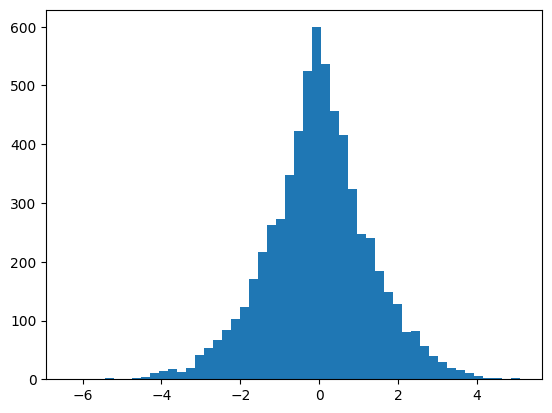

In [50]:
#distb of preactivation
plt.hist(hlPreReact.view(-1).tolist(), 50);

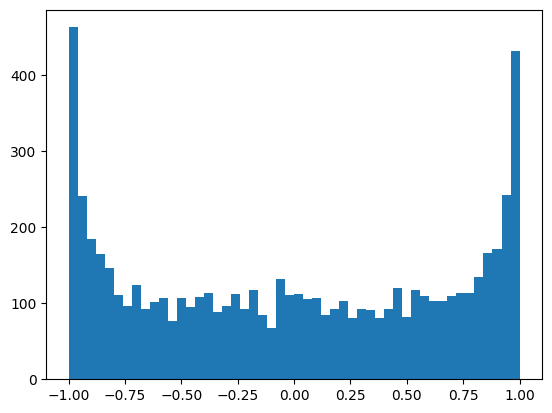

In [51]:
#after  fix tanh layer too saturated at init[para];
plt.hist(h.view(-1).tolist(), 50); 


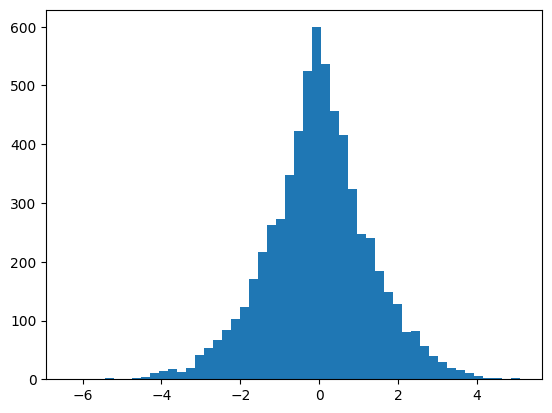

In [52]:
##after  fix tanh layer too saturated at init[para];
plt.hist(hlPreReact.view(-1).tolist(), 50);

In [53]:
# 4-dim example of the issue
logits = torch.tensor([0.0, 0.0, 4.000, 0.0]) #if 2High loss low else loss high
prob = torch.softmax(logits, dim=0)
loss = -prob[2].log()
prob, loss

(tensor([0.0174, 0.0174, 0.9479, 0.0174]), tensor(0.0535))

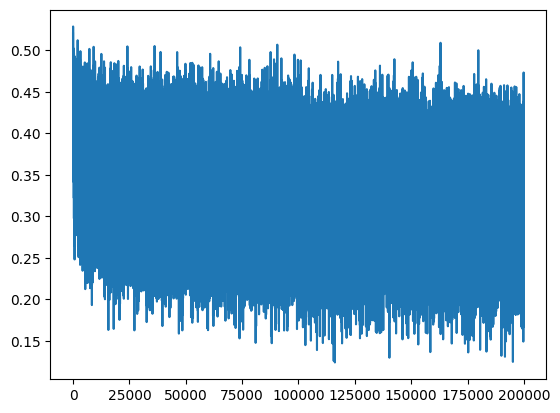

In [54]:
plt.plot(loss_i)

In [72]:
# calibrat the batch norm of the end of the training
with torch.no_grad():
    emb = C[xTrain]
    embCat = emb.view(emb.shape[0], -1)
    hlPreReact = embCat @ w1 + b1
    #measure the mean/std over the entire training set
    bnmean = hlPreReact.mean(0, keepdim=True)
    bnstd = hlPreReact.std(0, keepdim=True)


In [79]:
@torch.no_grad()
def splitLoss(split):
    x, y = {
        'train': (xTrain, yTrain),
        'dev': (xDev, yDev),
        'test': (xTst, yTst)
    }[split]

    emb = C[x]
    embCat = emb.view(emb.shape[0], -1)
    
    hlPreReact = embCat @ w1 + b1 # hidden layer pre-activation
    #starndadizing Activation / Batch Norm .. || Read the papaer
    #hlPreReact = bngain * (hlPreReact - hlPreReact.mean(0, keepdim=True)) / (hlPreReact.std(0, keepdim=True)) + bnbias
    hlPreReact = bngain * (hlPreReact -bnmeanRunning) / bnstdRunning + bnbias

    h = torch.tanh(embCat @ w1 + b1)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

splitLoss('train')
splitLoss('dev')

train 2.983689546585083
dev 3.011362314224243


In [ ]:
# Loss Log

#original
train 2.13....
dev   2.16....

# fix softmax Confidatialy Wrong
train 2.07....
dev   2.13....

# fix tanh layer too saturated at init[para];
train 2.983689546585083
dev 3.011362314224243

In [9]:
g = torch.Generator().manual_seed(2147483647 + 10)
blocksiz=3
for _ in range(20):
    out = []
    contxt = [0] * blocksiz
    while True:
        emb = C[torch.tensor([contxt])]
        h = torch.tanh(emb.view(1, -1) @ w1 + b1)
        logits = h @ w2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        contxt = contxt[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))


mora.
kayanzieel.
nihahlia.
emmadiengrari.
azelynnelin.
shy.
jenre.
elissonnar.
kayzimilara.
noshibergihamies.
kin.
rethiklanthona.
ubrence.
ryyah.
faeli.
kay.
mustonah.
halina.
yansun.
zakelle.
